Weirdness below (e.g., in SEIR model - normal parameters, but with q = 1; in SIR model - normal parameters; with rho = 100)

In [3]:
import ODE_models_why as ODE_models
import Model_stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math

## Code Summary -- Recreating Poletti and Comparison with SEIR


In this file we try to recreate some of the results acheived by Poletti et. al. in their 2009 and 2012 papers. The aim is to get a feel for the model and make sure that the baseline code we have written is in working order. 

### 1.  Baseline parameters

The first item of business is to ensure that we are using the same parameters as Poletti. Many of Poletti's parameter assumptions are given as baseline values in the ODE_models module, however some have been changed to better reflect what we know about COVID.

In [4]:
recovery_days = 2.8 # average length of infection (current baseline from 2012)
gamma = 1/recovery_days # rate of recovery

beta_S = 0.5 # infection rate for symptomatic infectives
beta_A = 0.5 # infection rate for asymptomatic infectives

q = 0.85  # reduction factor for those with altered/adjusted behavior
p = 1     # probability of developing symptoms

avg_memory = 2.8   # average length of memory regarding active cases
nu  = 1/avg_memory  # rate of forgetting past "new case" counts

M_thresh = 0.01 # risk threshold 
m = 1/M_thresh

rho = 10 # speed of behavioral changes (1/days)

mu = 10**(-8)  # irrational exploration with fixed units

xi = 0.33333

og_params = ODE_models.get_params()

Now that we know we are using the baseline parameters that were used by Poletti, et. al. (at least in the 2012 paper), we are ready to simulate the model and plot the results. We will chose initial conditions from a reasonable estimation of the early stages of a pandemic.

In [5]:
## Set initial conditions
Sn_0  = (1 - 10**(-3))*(1-10**(-6))
Sa_0  = (1 - 10**(-3))*(10**(-6))
En_0 = 0
Ea_0 = 0
IS_0  = 10**(-3)
IAn_0 = 0
IAa_0 = 0
RS_0  = 0
RAn_0 = 0
RAa_0 = 0
M_0   = 0

# Simulate the ODE
initial_state = np.array([Sn_0,Sa_0,IS_0,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
initial_stateE = np.array([Sn_0,Sa_0,En_0, Ea_0, IS_0,IAn_0,IAa_0,RS_0,RAn_0,RAa_0,M_0])
time = np.arange(0,1000,0.005)

sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(og_params,))

simE_system = odeint(ODE_models.SEIRan_system, initial_stateE, time, args=(og_params,))

#### 1a. Basic Figures to check accuracy

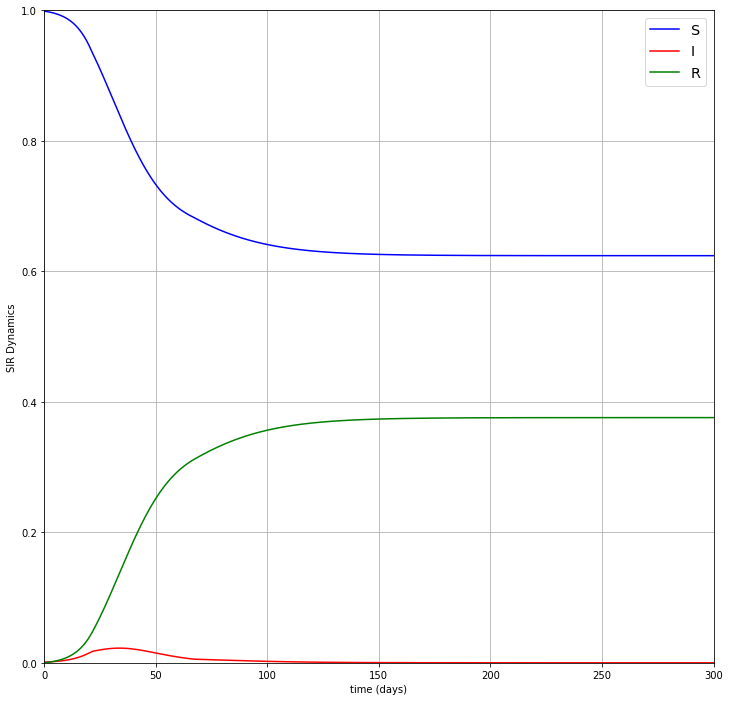

In [6]:
## Plot combined S, I, and R compartments. 

fin_time = 300

matplotlib.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

S = sim_system[:,0]+sim_system[:,1]
I = sim_system[:,2]+sim_system[:,3]+sim_system[:,4]
R = sim_system[:,5]+sim_system[:,6]+sim_system[:,7]

S_curve, = ax.plot(time, S, '-b')
I_curve, = ax.plot(time, I, '-r')
R_curve, = ax.plot(time, R, '-g')

ax.set(xlabel='time (days)', ylabel='SIR Dynamics')
ax.set_ylim((0,1))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend((S_curve,I_curve,R_curve),('S','I','R'),loc='best',fontsize='x-large')

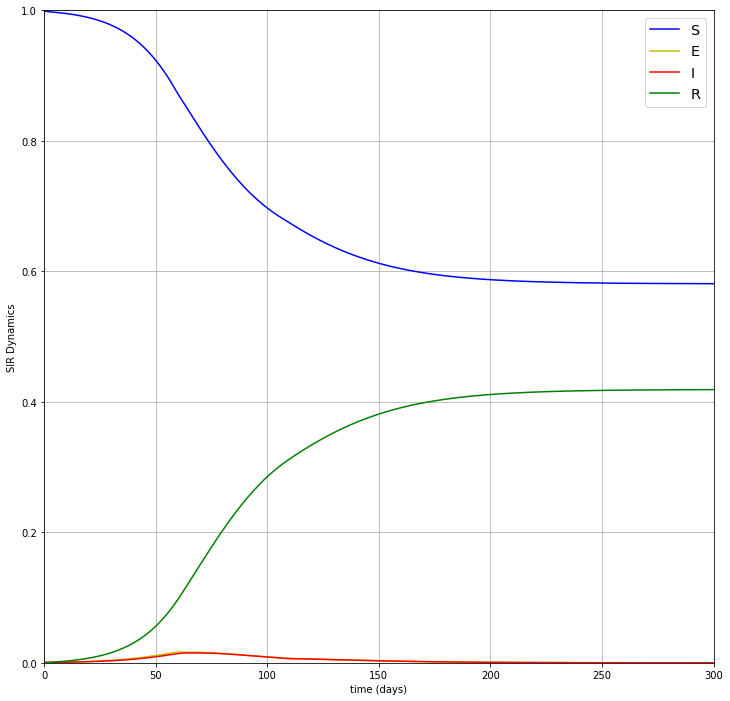

In [7]:
## Plot combined S, E, I, and R compartments. 

fin_time = 300

matplotlib.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

S = simE_system[:,0]+simE_system[:,1]
E = simE_system[:,2]+simE_system[:,3]
I = simE_system[:,4]+simE_system[:,5]+simE_system[:,6]
R = simE_system[:,7]+simE_system[:,8]+simE_system[:,9]

S_curve, = ax.plot(time, S, '-b')
E_curve, = ax.plot(time, E, 'y')
I_curve, = ax.plot(time, I, '-r')
R_curve, = ax.plot(time, R, '-g')

ax.set(xlabel='time (days)', ylabel='SIR Dynamics')
ax.set_ylim((0,1))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend((S_curve,E_curve,I_curve,R_curve),('S','E','I','R'),loc='best',fontsize='x-large')

Adding in the exposed compartment seems to slow the epidemic down (unsurprising) - exposed category currently not incorporated in equations for payoff / M - so perhaps it makes sense that this does not change too much.

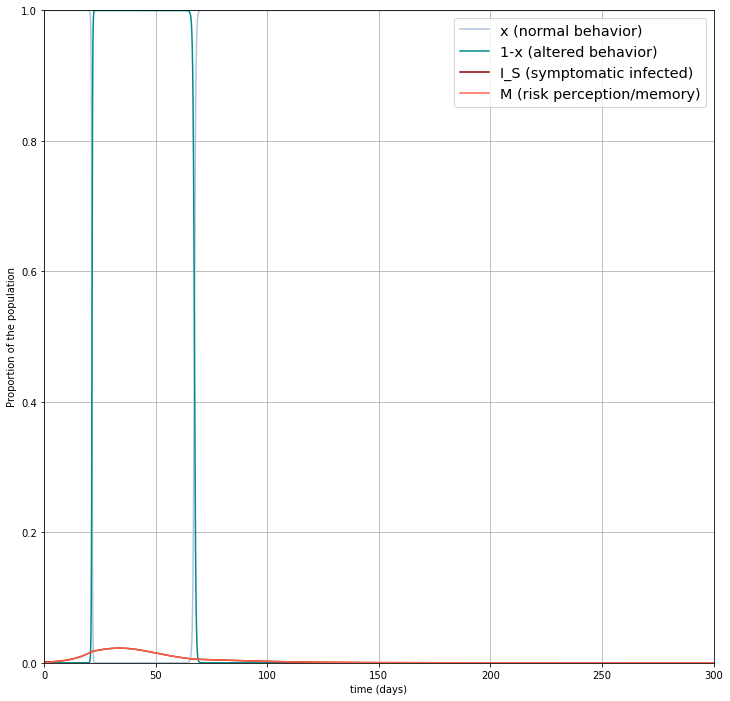

In [8]:
## Plot combined I_S and M with x

fin_time = 300

matplotlib.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

nonbehavior_comparts = sim_system[:,2]+sim_system[:,5]

x = (sim_system[:,0]+sim_system[:,3]+sim_system[:,6])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
x1 = (sim_system[:,1]+sim_system[:,4]+sim_system[:,7])/(np.sum(sim_system,axis=1)-nonbehavior_comparts-sim_system[:,-1])
I_S = sim_system[:,2]
M = sim_system[:,-1]

x_curve, = ax.plot(time, x, linestyle='-', c='lightsteelblue')
x1_curve, = ax.plot(time, x1, linestyle='-', c='darkcyan')
IS_curve, = ax.plot(time, I_S, linestyle='-', c='darkred')
M_curve, = ax.plot(time, M, linestyle='-', c='tomato')

ax.set(xlabel='time (days)', ylabel='Proportion of the population')
ax.set_ylim((0,1))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend((x_curve,x1_curve,IS_curve,M_curve),
          ('x (normal behavior)','1-x (altered behavior)','I_S (symptomatic infected)','M (risk perception/memory)'),
          loc='best',fontsize='x-large')

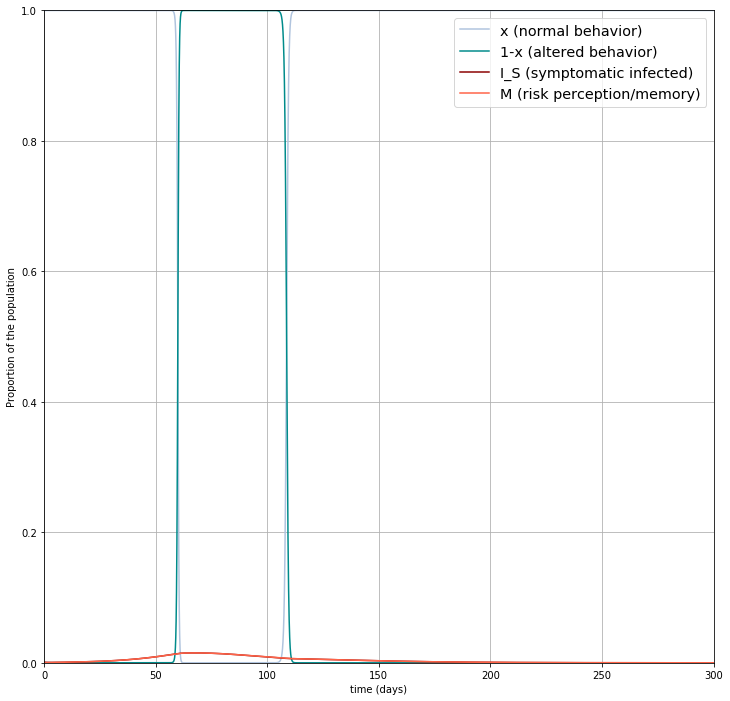

In [9]:
## Plot combined I_S and M with x

fin_time = 300

matplotlib.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

nonbehavior_comparts = simE_system[:,4]+simE_system[:,7]

x = (simE_system[:,0]+simE_system[:,2]+simE_system[:,5]+simE_system[:,8])/(np.sum(simE_system,axis=1)-nonbehavior_comparts-simE_system[:,-1])
x1 = (simE_system[:,1]+simE_system[:,3]+simE_system[:,6]+simE_system[:,9])/(np.sum(simE_system,axis=1)-nonbehavior_comparts-simE_system[:,-1])
I_S = simE_system[:,4]
M = simE_system[:,-1]

x_curve, = ax.plot(time, x, linestyle='-', c='lightsteelblue')
x1_curve, = ax.plot(time, x1, linestyle='-', c='darkcyan')
IS_curve, = ax.plot(time, I_S, linestyle='-', c='darkred')
M_curve, = ax.plot(time, M, linestyle='-', c='tomato')

ax.set(xlabel='time (days)', ylabel='Proportion of the population')
ax.set_ylim((0,1))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend((x_curve,x1_curve,IS_curve,M_curve),
          ('x (normal behavior)','1-x (altered behavior)','I_S (symptomatic infected)','M (risk perception/memory)'),
          loc='best',fontsize='x-large')

Again, nothing appears to be fundamentally different between the two models (in terms of behavior) - the speed at which people change their behavior is slower, but that appears to be about all?

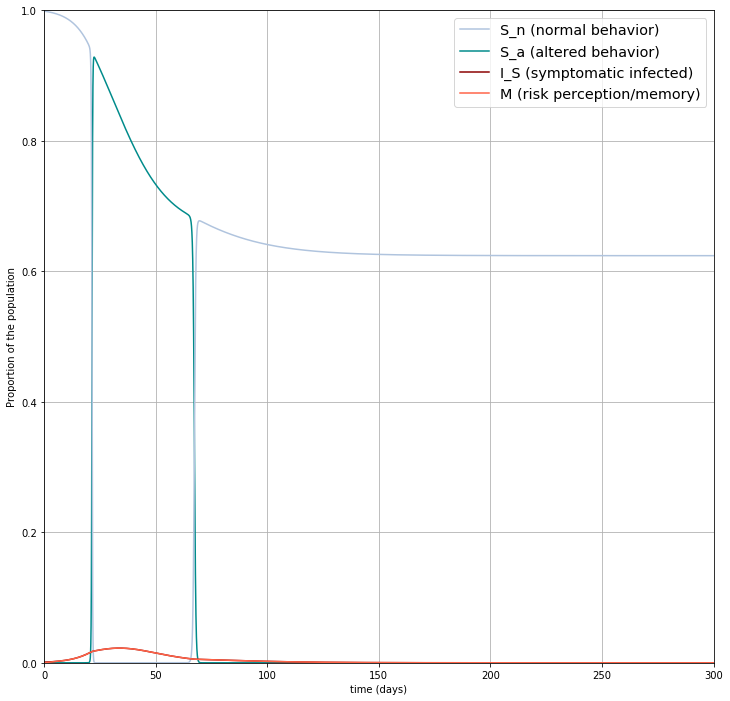

In [10]:
## Plot combined I_S and M with x

fin_time = 300

matplotlib.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

S_a = sim_system[:,1]
S_n = sim_system[:,0]
I_S = sim_system[:,2]
M   = sim_system[:,-1]

Sa_curve, = ax.plot(time, S_a, linestyle='-', c='darkcyan')
Sn_curve, = ax.plot(time, S_n, linestyle='-', c='lightsteelblue')
IS_curve, = ax.plot(time, I_S, linestyle='-', c='darkred')
M_curve, = ax.plot(time, M, linestyle='-', c='tomato')

ax.set(xlabel='time (days)', ylabel='Proportion of the population')
ax.set_ylim((0,1))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend((Sn_curve,Sa_curve,IS_curve,M_curve),
          ('S_n (normal behavior)','S_a (altered behavior)','I_S (symptomatic infected)','M (risk perception/memory)'),
          loc='best',fontsize='x-large')

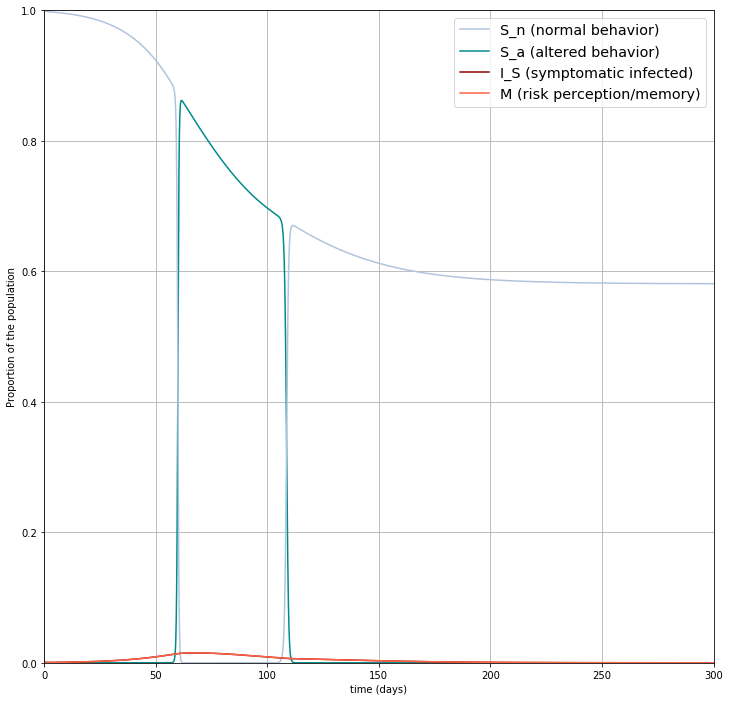

In [11]:
## Plot combined I_S and M with x

fin_time = 300

matplotlib.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

S_a = simE_system[:,1]
S_n = simE_system[:,0]
I_S = simE_system[:,4]
M   = simE_system[:,-1]

Sa_curve, = ax.plot(time, S_a, linestyle='-', c='darkcyan')
Sn_curve, = ax.plot(time, S_n, linestyle='-', c='lightsteelblue')
IS_curve, = ax.plot(time, I_S, linestyle='-', c='darkred')
M_curve, = ax.plot(time, M, linestyle='-', c='tomato')

ax.set(xlabel='time (days)', ylabel='Proportion of the population')
ax.set_ylim((0,1))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend((Sn_curve,Sa_curve,IS_curve,M_curve),
          ('S_n (normal behavior)','S_a (altered behavior)','I_S (symptomatic infected)','M (risk perception/memory)'),
          loc='best',fontsize='x-large')

Again, similar: when the behavior changes is different, but not much else.

#### 1b. Replicating Poletti's 2012 figures

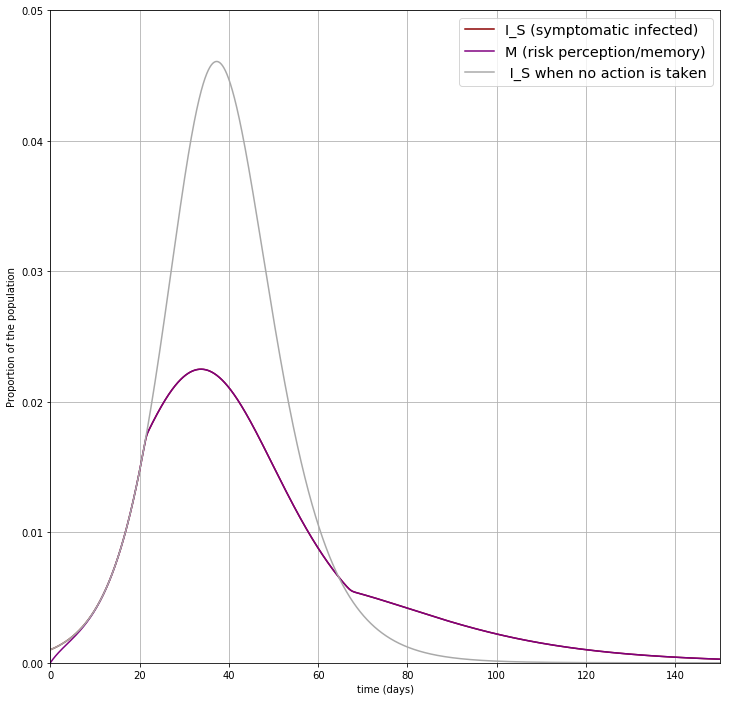

In [12]:
## Poletti's Fig 2a

fin_time = 150

matplotlib.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

I_S = sim_system[:,2]
M   = sim_system[:,-1]

IS_curve, = ax.plot(time, I_S, linestyle='-', c='darkred')
M_curve, = ax.plot(time, M, linestyle='-', c='purple')

# also plot what happens when the population is not responsive. 
params_noresponse = ODE_models.get_params(gamma,beta_S, beta_A, 1, p, nu, m, rho, mu)
noresponse_sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params_noresponse,))

IS_noresponse = noresponse_sim_system[:,2]
IS_noresponse_curve, = ax.plot(time, IS_noresponse, linestyle='-', c='darkgray')

ax.set(xlabel='time (days)', ylabel='Proportion of the population')
ax.set_ylim((0,0.05))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend((IS_curve,M_curve,IS_noresponse_curve),
          ('I_S (symptomatic infected)','M (risk perception/memory)',' I_S when no action is taken'),
          loc='best',fontsize='x-large')


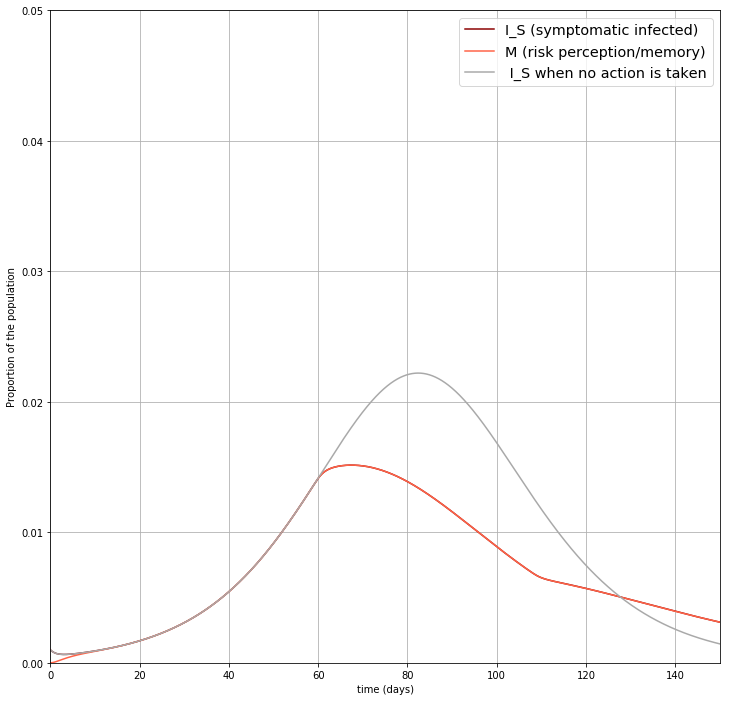

In [13]:
## Poletti's Fig 2a

fin_time = 150

matplotlib.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()

I_S = simE_system[:,4]
M   = simE_system[:,-1]

IS_curve, = ax.plot(time, I_S, linestyle='-', c='darkred')
M_curve, = ax.plot(time, M, linestyle='-', c='tomato')

# also plot what happens when the population is not responsive. 
params_noresponse = ODE_models.get_params(gamma,beta_S, beta_A, 1, p, nu, m, rho, mu, xi)
noresponse_simE_system = odeint(ODE_models.SEIRan_system, initial_stateE, time, args=(params_noresponse,))

IS_noresponseE = noresponse_simE_system[:,4]
IS_noresponseE_curve, = ax.plot(time, IS_noresponseE, linestyle='-', c='darkgray')

ax.set(xlabel='time (days)', ylabel='Proportion of the population')
ax.set_ylim((0,0.05))
ax.set_xlim((0,fin_time))
ax.grid()
ax.legend((IS_curve,M_curve,IS_noresponseE_curve),
          ('I_S (symptomatic infected)','M (risk perception/memory)',' I_S when no action is taken'),
          loc='best',fontsize='x-large')




Trajectory of I_S looks different - in both, M and I_S coincide.

### 2. Recreating Poletti's parameter exploration

Now that we know the code works and is "identical" to Poletti's, we can start to explore how the parameters vary the dynamics. This is important for getting a grasp on how the code works.

#### 2a. Use Poletti's baseline parameters and vary parameters from Fig. 3

Though this doesn't give us very much new information, it will be helpful in learning about what each of these parameters effectually means in the model. In particular, $\rho$, needs to be understood better, and $1/m$ and $q$ are important social determinants that could potentially be changed in order to increase the effectiveness of an intervention.

_Note on understanding $\mathbf{\rho}$_:

Don't forget that Figure 2c in the 2012 paper gives the relationship between $\rho$ and the time delay. $\rho\in[1,100]$ is reasonable because it correspondes to a response delay of 1 day ($\rho = 100$) to 2 weeks ($\rho = 1$). A value of $\rho=10$ corresponds to a 4 day delay.  

/Applications/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


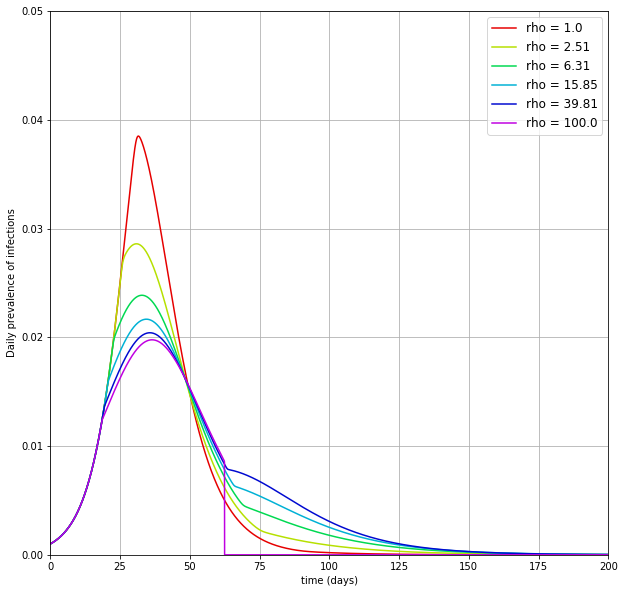

In [14]:
## Keep Poletti baseline but change rho

time = np.arange(0,200,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,200))
ax.grid()

# test a time delay of 2 weeks vs 1 day. 
for i in np.linspace(0,2,6):
    rho_test = 10**i
    params = ODE_models.get_params(rho=rho_test)
    
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
    line2, = ax.plot(time, sim_system[:,2], c=col, linestyle='-')
    
    legend_curves += (line2,)
    legend_names += ('rho = {}'.format(round(rho_test,2)),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')
    

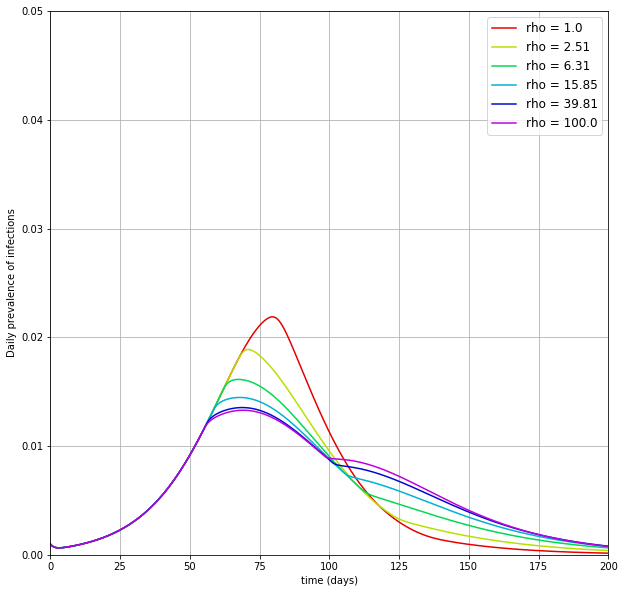

In [15]:
## SEIR version
## Keep Poletti baseline but change rho

time = np.arange(0,200,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,200))
ax.grid()

# test a time delay of 2 weeks vs 1 day. 
for i in np.linspace(0,2,6):
    rho_test = 10**i
    params = ODE_models.get_params(rho=rho_test)
    
    simE_system = odeint(ODE_models.SEIRan_system, initial_stateE, time, args=(params,))
    
    col = next(color_iter)
    #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
    line2, = ax.plot(time, simE_system[:,4], c=col, linestyle='-')
    
    legend_curves += (line2,)
    legend_names += ('rho = {}'.format(round(rho_test,2)),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')
    

/Applications/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


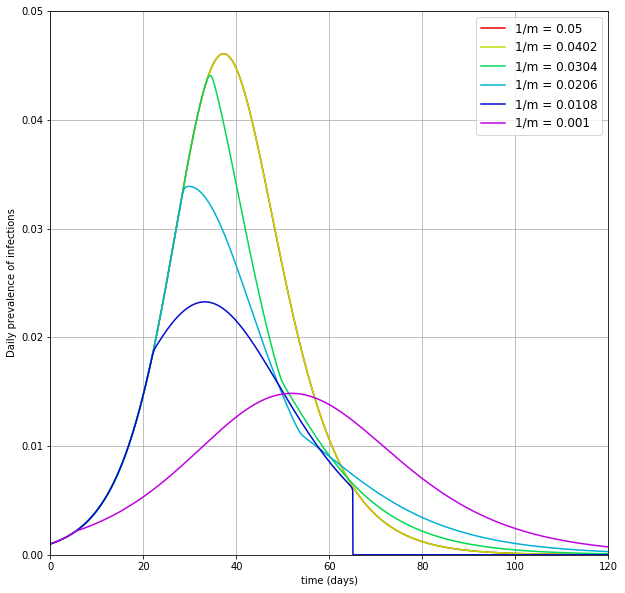

In [16]:
## Keep Poletti baseline but change 1/m

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,120))
ax.grid()

'''
    Note that even when there is no behavioral change, the peak is only 5/100 people. 
    So... we want to test values for 1/m that make sense and have some affect. 
    I tend to think about it as # of people out of 100 or 1000 or 10000.
    
    Let's test what happens when it's between 5:100 and 1:1000.
'''
for M_thresh_test in np.linspace(0.05,0.001,6):
    
    params = ODE_models.get_params(m=1/M_thresh_test)
    
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
    line2, = ax.plot(time, sim_system[:,2], c=col, linestyle='-')
    
    legend_curves += (line2,)
    legend_names += ('1/m = {}'.format(round(M_thresh_test,4)),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

Notice in the figure above. 

1. We have some sort of problem with integrating when 1/m = 0.0108. I'm not sure what is causing this but Python says "Excess work done on this call (perhaps wrong Dfun type)". 
2. There seems to be a big jump between 0.0108 and 0.001. I wonder if this is driven in part by the concavity of the baseline curve. Could this mean a "bifurcation" of sorts in 1/m? It seems like the behavior is signifcantly different between the two and if we want real "flatten the curve" senario, we want to see the magenta shape not the dark blue shape.

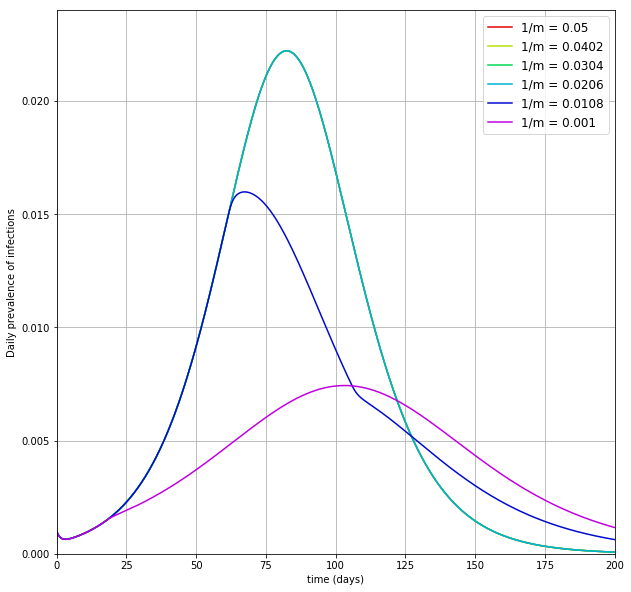

In [17]:
## SEIR version
## Keep Poletti baseline but change 1/m

time = np.arange(0,200,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.024))
ax.set_xlim((0,200))
ax.grid()


for M_thresh_test in np.linspace(0.05,0.001,6):
    
    params = ODE_models.get_params(m=1/M_thresh_test)
    
    simE_system = odeint(ODE_models.SEIRan_system, initial_stateE, time, args=(params,))
    
    col = next(color_iter)
    #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
    line2, = ax.plot(time, simE_system[:,4], c=col, linestyle='-')
    
    legend_curves += (line2,)
    legend_names += ('1/m = {}'.format(round(M_thresh_test,4)),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

/Applications/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


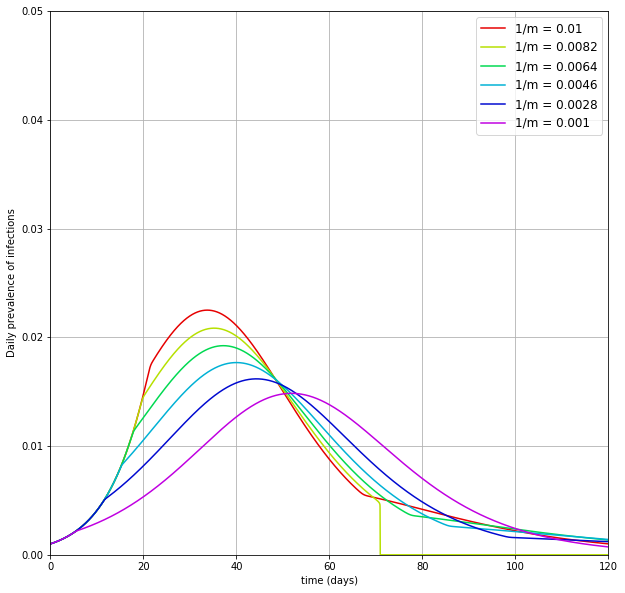

In [18]:
## Keep Poletti baseline but change 1/m
## Zoom in on 0.001 and 0.001

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,120))
ax.grid()

'''
    Before we saw that there is was a big difference between 0.01 and 0.001. 
    Let's do it again but focus on what happens in this space.
'''
for M_thresh_test in np.linspace(0.01,0.001,6):
    
    params = ODE_models.get_params(m=1/M_thresh_test)
    
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
    line2, = ax.plot(time, sim_system[:,2], c=col, linestyle='-')
    
    legend_curves += (line2,)
    legend_names += ('1/m = {}'.format(round(M_thresh_test,4)),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

Based on the above figure, perhaps we do just see a smooth transision of curve shape (and no bifurcation...)

It does seem that more change happens faster as you get smaller. As you get larger, the change becomes less durastic. 

Note also that for $1/m >0.0046$ (and maybe $1/m = 0.0028$ as well?) there is a sharp change in behavior. However for $1/m = 0.001$, its is almost entirely smooth. The curve is already shallow enough that a collective behavior switch won't changed the dervative very much. 

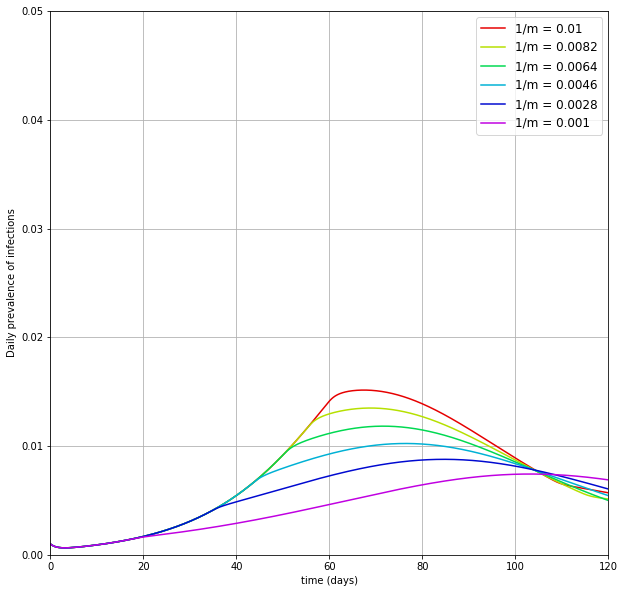

In [47]:
## SEIR 

## Keep Poletti baseline but change 1/m
## Zoom in on 0.001 and 0.001

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,120))
ax.grid()

'''
    Before we saw that there is was a big difference between 0.01 and 0.001. 
    Let's do it again but focus on what happens in this space.
'''
for M_thresh_test in np.linspace(0.01,0.001,6):
    
    params = ODE_models.get_params(m=1/M_thresh_test)
    
    simE_system = odeint(ODE_models.SEIRan_system, initial_stateE, time, args=(params,))
    
    col = next(color_iter)
    #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
    line2, = ax.plot(time, simE_system[:,4], c=col, linestyle='-')
    
    legend_curves += (line2,)
    legend_names += ('1/m = {}'.format(round(M_thresh_test,4)),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

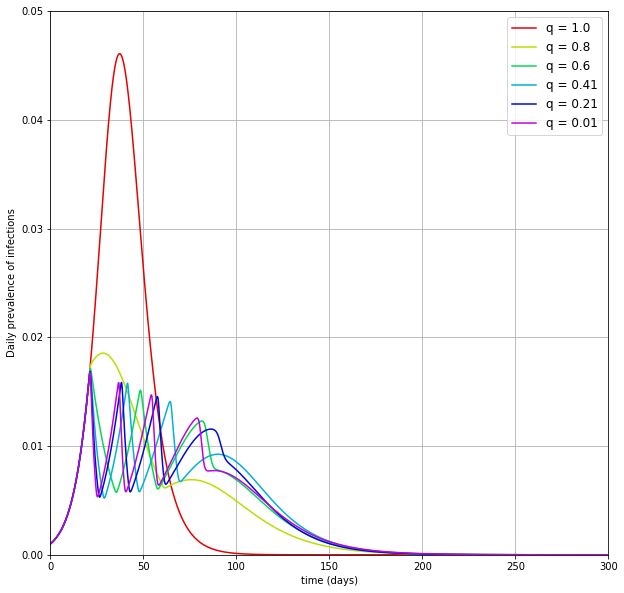

In [49]:
## Keep Poletti baseline but change q

time = np.arange(0,300,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,300))
ax.grid()

# q has such an important effect and it can really range from 0 to 1. 
# Let's try it all and we can zoom in later. 
for q_test in np.linspace(1,0.01,6):
    
    params = ODE_models.get_params(q=q_test)
    
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
    line2, = ax.plot(time, sim_system[:,2], c=col, linestyle='-')
    
    legend_curves += (line2,)
    legend_names += ('q = {}'.format(round(q_test,2)),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

It is interesting that with the fixed $\rho = 10$ and $1/m = 0.01$ as the baseline values, not much changes once you have a $40\%$ reduction in contact for $b_a$. Perhaps that's why Poletti only looked at $q\in[0.6,1]$. Let's zoom in on that a bit more. Then we can look at how $\rho$, $1/m$, and $q$ all interact together.

/Applications/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


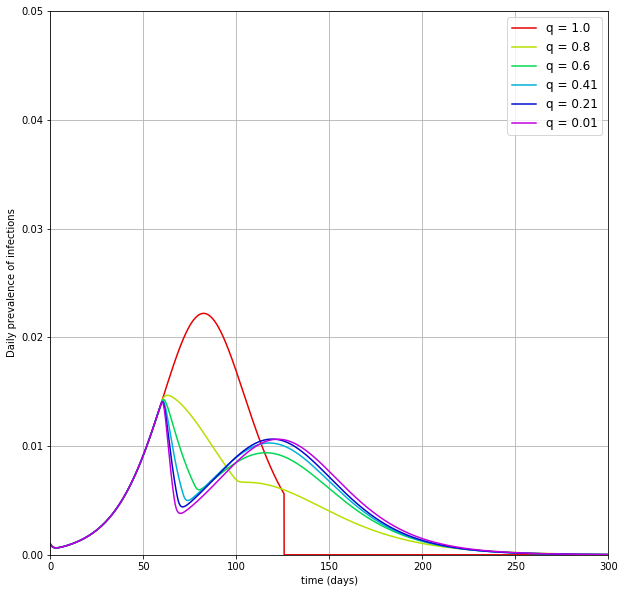

In [48]:
## SEIR

## Keep Poletti baseline but change q

time = np.arange(0,300,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,300))
ax.grid()

# q has such an important effect and it can really range from 0 to 1. 
# Let's try it all and we can zoom in later. 
for q_test in np.linspace(1,0.01,6):
    
    params = ODE_models.get_params(q=q_test)
    
    simE_system = odeint(ODE_models.SEIRan_system, initial_stateE, time, args=(params,))
    
    col = next(color_iter)
    #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
    line2, = ax.plot(time, simE_system[:,4], c=col, linestyle='-')
    
    legend_curves += (line2,)
    legend_names += ('q = {}'.format(round(q_test,2)),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

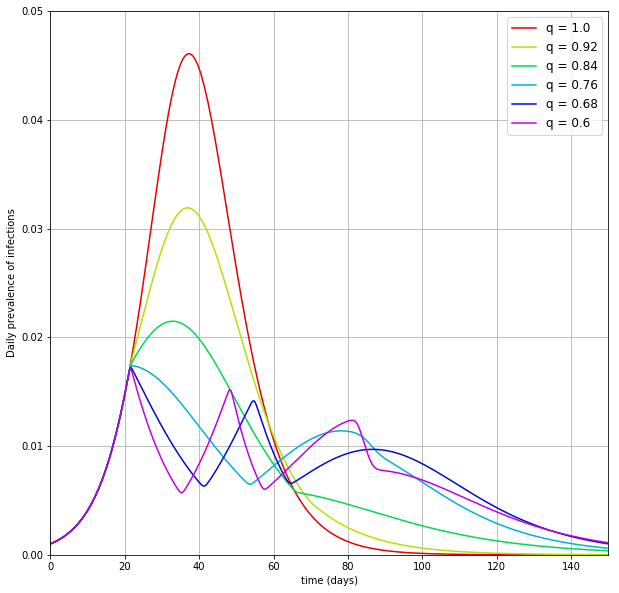

In [50]:
## Keep Poletti baseline but change q

time = np.arange(0,150,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,150))
ax.grid()

# q has such an important effect and it can really range from 0 to 1. 
# Let's try it all and we can zoom in later. 
for q_test in np.linspace(1,0.6,6):
    
    params = ODE_models.get_params(q=q_test)
    
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
    line2, = ax.plot(time, sim_system[:,2], c=col, linestyle='-')
    
    legend_curves += (line2,)
    legend_names += ('q = {}'.format(round(q_test,2)),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

/Applications/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


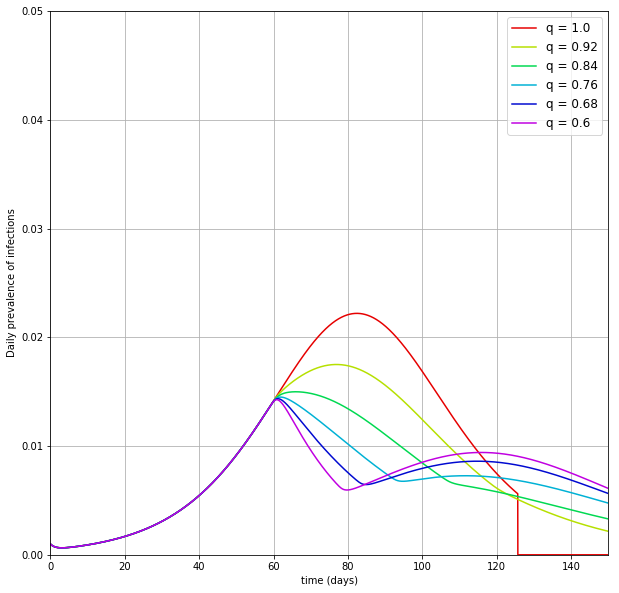

In [51]:
## Keep Poletti baseline but change q

time = np.arange(0,150,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,150))
ax.grid()

# q has such an important effect and it can really range from 0 to 1. 
# Let's try it all and we can zoom in later. 
for q_test in np.linspace(1,0.6,6):
    
    params = ODE_models.get_params(q=q_test)
    
    simE_system = odeint(ODE_models.SEIRan_system, initial_stateE, time, args=(params,))
    
    col = next(color_iter)
    #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
    line2, = ax.plot(time, simE_system[:,4], c=col, linestyle='-')
    
    legend_curves += (line2,)
    legend_names += ('q = {}'.format(round(q_test,2)),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

#### 2b. Adjust Poletti's baseline parameters to test their interacting effect.

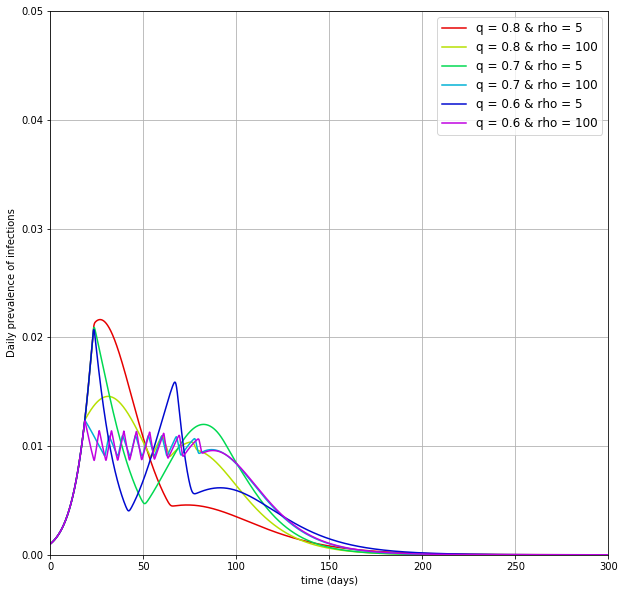

In [36]:
## Observe interaction between rho and q

time = np.arange(0,300,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,300))
ax.grid()

q_set = [0.8,0.7,0.6]
rho_set = [5,100]   # approximatly 5-6 days vs 1 day
for q_test in q_set:
    for rho_test in rho_set:
    
        params = ODE_models.get_params(q=q_test,rho=rho_test)

        sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))

        col = next(color_iter)
        #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
        line2, = ax.plot(time, sim_system[:,2], c=col, linestyle='-')

        legend_curves += (line2,)
        legend_names += ('q = {} & rho = {}'.format(q_test,rho_test),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

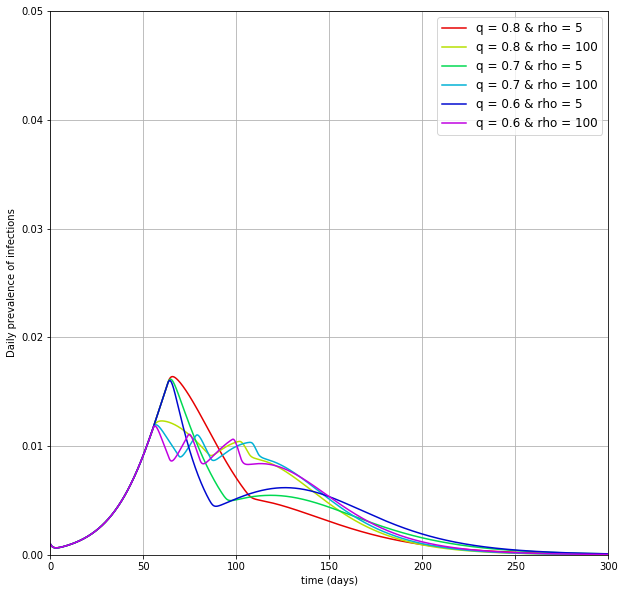

In [37]:
## SEIR

## Observe interaction between rho and q

time = np.arange(0,300,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,300))
ax.grid()

q_set = [0.8,0.7,0.6]
rho_set = [5,100]   # approximatly 5-6 days vs 1 day
for q_test in q_set:
    for rho_test in rho_set:
    
        params = ODE_models.get_params(q=q_test,rho=rho_test)

        simE_system = odeint(ODE_models.SEIRan_system, initial_stateE, time, args=(params,))

        col = next(color_iter)
        #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
        line2, = ax.plot(time, simE_system[:,4], c=col, linestyle='-')

        legend_curves += (line2,)
        legend_names += ('q = {} & rho = {}'.format(q_test,rho_test),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

In [ ]:
## Observe interaction between 1/m and q

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,120))
ax.grid()

q_set = [0.8,0.7,0.6]
Mthresh_set = [0.02,0.01]  
for q_test in q_set:
    for Mthresh_test in Mthresh_set:
    
        params = ODE_models.get_params(q=q_test,m=1/Mthresh_test)

        sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))

        col = next(color_iter)
        #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
        line2, = ax.plot(time, sim_system[:,2], c=col, linestyle='-')

        legend_curves += (line2,)
        legend_names += ('q = {} & 1/m = {}'.format(q_test,Mthresh_test),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

In [ ]:
## Observe interaction between 1/m and rho

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.05))
ax.set_xlim((0,120))
ax.grid()

rho_set = [1,10,100]  # approximately 14 day delay, 4 day delay, and 1 day delay.
Mthresh_set = [0.02,0.01]   
for rho_test in rho_set:
    for Mthresh_test in Mthresh_set:
    
        params = ODE_models.get_params(rho=rho_test,m=1/Mthresh_test)

        sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))

        col = next(color_iter)
        #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
        line2, = ax.plot(time, sim_system[:,2], c=col, linestyle='-')

        legend_curves += (line2,)
        legend_names += ('rho = {} & 1/m = {}'.format(rho_test,Mthresh_test),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

#### 2c. Generate  parameter statistics on the epidemic

In [ ]:
## Look at the change in the epidemic characteristics based on changing q

time = np.arange(0,120,0.005)

final_size = []
peak_size = []
peak_day = []

q_test_set = np.arange(0.4,1.025,0.025)

for q_test in q_test_set:
    
    params = ODE_models.get_params(q=q_test)
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))
    
    final_size.append(Model_stats.final_epi_size(sim_system, time))
    
    p_day, p_size = Model_stats.daily_peak(sim_system,time,peak_type='I_S', data_type='SIR')
    peak_size.append(p_size)
    peak_day.append(p_day)

final_size = np.array(final_size)
peak_size = np.array(peak_size)
peak_day = np.array(peak_day)

In [ ]:
matplotlib.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()

ax.set(xlabel='Reduction of contact (q)', ylabel='Final size of epidemic')
ax.set_ylim((0.2,0.6))
ax.set_xlim((0.4,1))
ax.grid()

ax.plot(q_test_set, final_size, '-o', c='forestgreen')

Those two peaks around $q=0.65$ and $q=0.77$ are very wierd. I wonder what is causing that?

Thoughts ... perhaps it has to do with a sweet spot where $q$ doesn't have a large enough effect on the transmission rate that we still observe a peak of sorts but it is spread out so that all in all a lot of people were at one time under that "flattened" curve? 

Before we move onto how the other characteristics of the epidemic depend on $q$, let's look more closely at what happens for $q\in[0.6,0.8]$.

In [ ]:
## Keep Poletti baseline but change q

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.02))
ax.set_xlim((0,120))
ax.grid()

# q has such an important effect and it can really range from 0 to 1. 
# Let's try it all and we can zoom in later. 
for q_test in np.linspace(0.8,0.6,6):
    
    params = ODE_models.get_params(q=q_test)
    
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
    line2, = ax.plot(time, sim_system[:,2], c=col, linestyle='-')
    
    legend_curves += (line2,)
    legend_names += ('q = {}'.format(round(q_test,2)),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

Okay... so we see these relatively large peaks. It's good that we never have a really large amount all at once but these do mean that a bunch recover and we have low counts then we have more all at once again. 

Let's look at a more refined parameter diagram with total final size of the epidemic.

In [ ]:
q_test_set = np.arange(0.6,0.801,0.005)

final_size = []

for q_test in q_test_set:
    
    params = ODE_models.get_params(q=q_test)
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))
    
    final_size.append(Model_stats.final_epi_size(sim_system, time))
    
final_size = np.array(final_size)

matplotlib.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()

ax.set(xlabel='Reduction of contact (q)', ylabel='Final size of epidemic')
ax.set_ylim((0.34,0.4))
ax.set_xlim((0.6,0.8))
ax.grid()

ax.plot(q_test_set, final_size, '-o', c='forestgreen')

In [ ]:
## Keep Poletti baseline but change q

time = np.arange(0,120,0.005)
colors = ['#e60000','#b6e000','#00d951','#00b1d5','#0009d0','#c000e1']
color_iter = iter(colors)

matplotlib.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()
legend_curves = tuple()
legend_names = tuple()

ax.set(xlabel='time (days)', ylabel='Daily prevalence of infections')
ax.set_ylim((0,0.02))
ax.set_xlim((0,120))
ax.grid()

# q has such an important effect and it can really range from 0 to 1. 
# Let's try it all and we can zoom in later. 
q_set = np.array([0.65,0.675,0.725,0.75,0.775,0.8])
for q_test in q_set:
    
    params = ODE_models.get_params(q=q_test)
    
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))
    
    col = next(color_iter)
    #line1, = ax.plot(time, sim_system[:,-1], c=col, linestyle='--')
    line2, = ax.plot(time, sim_system[:,2], c=col, linestyle='-')
    
    legend_curves += (line2,)
    legend_names += ('q = {}'.format(round(q_test,2)),)
    

ax.legend(legend_curves, legend_names, loc='best',fontsize='large')

In [ ]:
q_test_set = np.arange(0.2,0.6,0.01)

final_size = []

for q_test in q_test_set:
    
    params = ODE_models.get_params(q=q_test)
    sim_system = odeint(ODE_models.SIRan_system, initial_state, time, args=(params,))
    
    final_size.append(Model_stats.final_epi_size(sim_system, time))
    
final_size = np.array(final_size)

matplotlib.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()

ax.set(xlabel='Reduction of contact (q)', ylabel='Final size of epidemic')
ax.set_ylim((0.3,0.4))
ax.set_xlim((0.2,0.6))
ax.grid()

ax.plot(q_test_set, final_size, '-o', c='forestgreen')

In [ ]:
matplotlib.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()

ax.set(xlabel='Reduction of contact (q)', ylabel='Peak size')
ax.set_ylim((0,0.05))
ax.set_xlim((0.4,1))
ax.grid()

ax.plot(q_test_set, peak_size, '-o', c='forestgreen')

This is what Poletti et. al got as well. It seems like right around $q=0.8$ is where you switch from having a peak post intervetion vs having a delayed result of intervention.

NameError: name 'q_test_set' is not defined

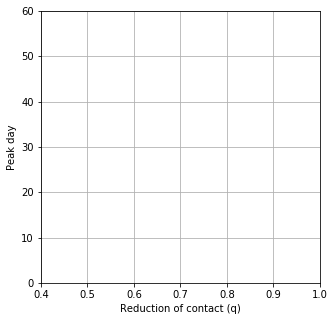

In [19]:
matplotlib.rcParams['figure.figsize'] = [5,5]
fig, ax = plt.subplots()

ax.set(xlabel='Reduction of contact (q)', ylabel='Peak day')
ax.set_ylim((0,60))
ax.set_xlim((0.4,1))
ax.grid()

ax.plot(q_test_set, peak_day, '-o', c='forestgreen')

We again see a paradigm shift when $q\approx 0.75$. This day 22 corresponds to the day that the shift in beahvior occurs when $1/m$ and $\rho$ take their Poletti baseline values. Here we also see a leveling off of the peak day since it will approach the natural peak.